# Handling time-constant singularities in integrate-and-fire neurons

This notebook details how NEST handles the numerical instability of the exact integration propagator matrix $P = e^{A h}$ which arise if $\tau_m\approx \tau_{\text{syn}}$. For an overview over exact integration of integrate-and-fire neuron subthreshold dynamics, please see `exact-integration.rst`.

We illustrate the approach for neurons with alpha-shaped currents, where the synaptic current is described by two differential equations. For exponential-shaped currents, a similar but simpler treatment applies.

The singularity-handling code is implemented in `libnestutil/iaf_propagator.[h,cpp]`.

## Preparations

We use SymPy to allow symbolic analysis of the propagator matrices and their limits.

In [1]:
import sympy as sp
from sympy.matrices import zeros
sp.init_printing(use_latex=True)

Introduce formal variables for time constants, capacitance and time step $h$.

In [2]:
tau_m, tau_s, C_m, h = sp.symbols('tau_m, tau_s, C_m, h')

## The ODE matrix

The following matrix describes the ODE system for synaptic current and membrane potential (bottom row). It applies for singular and non-singular cases.

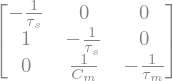

In [3]:
A = sp.Matrix([[-1/tau_s, 0, 0], [1, -1/tau_s ,0], [0, 1/C_m, -1/tau_m]])
A

## Propagator in the non-singular case ($\tau_m\neq \tau_s$) 

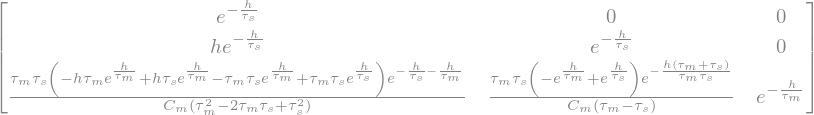

In [4]:
P = sp.simplify(sp.exp(A * h))
P

- The entries in the first two rows of $P$ are unproblematic, as is $P_{33}$.
- In the first two entries on the bottom row, $P_{31}$ and $P_{32}$, the denominators will vanish for $\tau_m\to\tau_s$.
- $P_{32}$ also appears in the propagator matrix for the case of exponential synaptic currents.

## Propagator in the singular case ($\tau_m = \tau_s$) 

In this case, we have

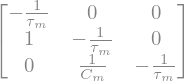

In [5]:
A_s = sp.Matrix([[-1/tau_m, 0, 0],[1, -1/tau_m, 0],[0, 1/C_m, -1/tau_m]])
A_s

and the propagator becomes

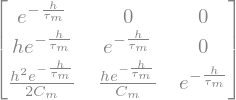

In [6]:
P_s = sp.simplify(sp.exp(A_s * h))
P_s

- This is well-formed and non-singular.
- The "unproblematic" matrix elements agree with the non-singular case.

## Numeric stability of propagator elements

We will now show that the matrix elements of the non-singular case converge to those in the general case, so that we have overall
$$
\lim_{\tau_s\to\tau_m} P = P_s\;.
$$

Using symbolic algebra we find for $\lim_{\tau_s\to\tau_m} P_{31} = P_{s,31}$:


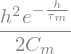

In [7]:
P_31 = P.row(2).col(0)[0]
P_31_l = sp.limit(P_31, tau_s, tau_m)
P_31_l

In [8]:
P_31_l == P_s.row(2).col(0)[0]

True

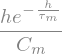

In [9]:
P_32 = P.row(2).col(1)[0]
P_32_l = sp.limit(P_32, tau_s, tau_m)
P_32_l

In [10]:
P_32_l == P_s.row(2).col(1)[0]

True

## Approximation in the vicinity of the singularity

Since the propagator elements converge to the solution for the singular case, we can approximate the matrix elements near the singularity by expanding around $\tau_m$. We obtain

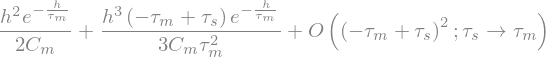

In [11]:
P_31.series(x=tau_s, x0=tau_m, n=2)

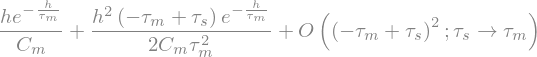

In [12]:
P_32.series(x=tau_s, x0=tau_m, n=2)

We thus have 

\begin{align}
P_{31} &= P_{s, 31} + \frac{2h}{3\tau_m^2}P_{s, 31}(\tau_s-\tau_m) + \mathcal{O}((\tau_s-\tau_m)^2)\\ 
P_{32} &= P_{s, 32} + \frac{h}{2\tau_m^2}P_{s, 32}(\tau_s-\tau_m) + \mathcal{O}((\tau_s-\tau_m)^2)
\end{align}

Focusing on $P_{32}$ and dropping the quadratic term, we obtain
$$
\left|\frac{P_{32}-P_{s, 32}}{P_{s, 32}}\right|\approx \left|\frac{h(\tau_s-\tau_m)}{2\tau_m^2}\right| < 1
$$
where the inequality follows because $|\tau_s-\tau_m|\ll \tau_m$ by definition in the near-singular case and $h<\tau_m$ for all practical purposes.

Any violation of this inequality indicates numerical instability in the computation of $P_{32}$.

## Algorithm for singularity-handling

We use $P_{32}$ as an example here. There approach is the same for $P_{31}$.

1. We compute $P_{32}$ numerically. For $\tau_m=\tau_s$, this will result in $\infty$, but in IEEE754-compatible numerics, this will be represented correctly as an `inf` value.
2. For $|\tau_s-\tau_m|\geq 0.1\,\text{ms}$, we assume that all elements of $P$ are numerically well-behaved and use the computed $P_{32}$.
3. Otherwise, we compute the singular $P_{s, 32}$.
4. If $\tau_m=\tau_s$, we use $P_{s, 32}$ as the propagator element.
5. Otherwise (almost singular case), we compare the difference 
$$\Delta = P_{32}-P_{s, 32}$$
   to the linear term in the Taylor expansion
   $$P_{32, \text{lin}} = \frac{h}{2\tau_m^2}P_{s, 32}(\tau_s-\tau_m)$$
6. If 
   $$|\Delta| > 2P_{32, \text{lin}}$$
   the inequality derived is definitly violated. In this case, we use $P_{s,32}$, otherwise $P_{32}$.


## Exploration
We will now show that the stability criterion explained above leads to a reasonable behavior for $\tau_s\rightarrow\tau_m$

In [13]:
import nest
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
nest.set_verbosity('M_ERROR')


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: stinebuu_propagator_class@e1bd3324d
 Built: Oct 17 2022 21:35:01

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### Simulation

- Create one neuron for each value of `delta_tau`
- Drive neurons with a single spike
- Measure resulting membrane potential

In [14]:
tau_m = 10.
h = 0.1
delta_tau = np.hstack(([0.], np.logspace(-5, 0, 6)))

nest.ResetKernel()
nest.resolution = h

neurons = nest.Create('iaf_psc_alpha', n=len(delta_tau),
                      params={'tau_m': tau_m,
                              'tau_syn_ex': tau_m + delta_tau})
spike_gen = nest.Create('spike_generator', params={'spike_times': [1.]})
vm = nest.Create('voltmeter', params={'interval': h})

nest.Connect(spike_gen, neurons, syn_spec={'weight':100.})
nest.Connect(vm, neurons)

nest.Simulate(10 * tau_m)

v = pd.DataFrame.from_records(vm.events).set_index('times')

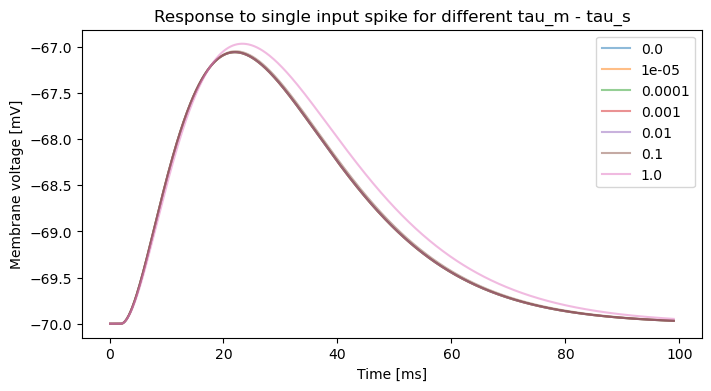

In [15]:
v.groupby('senders').V_m.plot(alpha=0.5, figsize=(8, 4));
plt.legend(delta_tau);
plt.xlabel('Time [ms]');
plt.ylabel('Membrane voltage [mV]');
plt.title('Response to single input spike for different tau_m - tau_s');

### Maximum of membrane potential

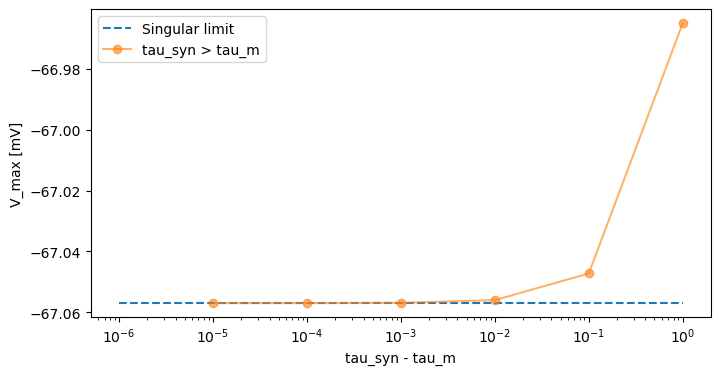

In [16]:
V_max = v.groupby('senders').V_m.max()
plt.figure(figsize=(8, 4));
plt.semilogx([1e-6, 1], [V_max.iloc[0], V_max.iloc[0]], '--');
plt.semilogx(delta_tau[1:], V_max.iloc[1:], 'o-', alpha=0.6);
plt.legend(('Singular limit', 'tau_syn > tau_m'));
plt.xlabel('tau_syn - tau_m');
plt.ylabel('V_max [mV]');

The maximum membrane potential converges smoothly against the singular limit, indicating that no numerical instabilities occur.

-----------------------------
### License

This file is part of NEST. Copyright (C) 2004 The NEST Initiative

NEST is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

NEST is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.